In [1]:
%matplotlib osx

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import numpy as np
from graphviz import Source
from qnetwork import *
from utils import *
import matplotlib.pyplot as plt
from env_sensing_error import *
from Plot_Path import *
import tensorflow as tf
import sys
from dra_planning import gen_dra_policy
from full_prod_DRA import *

/Users/gaoqitong/anaconda/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
def train(sess, env, qnet):
    
    global EXPLORATION_RATE
  
    summary_ops, summary_vars = build_summaries()

    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(SUMMARY_DIR, sess.graph)
    
    qnet.update_target()
    
    replay_buffer = ReplayBuffer(BUFFER_SIZE, RANDOM_SEED)
    
    for num_epi in range(MAX_EPISODES):

        s = env.reset()
        s = [list(np.unravel_index(s, env.shape))]

        ep_reward = 0
        ep_ave_max_q = 0
        
        reward_list = []

        for j in range(MAX_EPISODE_LEN):

            a = np.argmax(qnet.predict_q(np.reshape(s, (1, qnet.state_dim))))
    
            if np.random.rand(1) < EXPLORATION_RATE:
                s2, r, terminal, info = env.step(np.random.randint(0,qnet.action_dim))
            else:
                s2, r, terminal, info = env.step(a)
            
            s2 = list(np.unravel_index(s2, env.shape))

            replay_buffer.add(np.reshape(s, (qnet.state_dim,)), np.reshape(a, (1,)), r,
                              terminal, np.reshape(s2, (qnet.state_dim,)))

            # Keep adding experience to the memory until
            # there are at least minibatch size samples
            if replay_buffer.size() > MINIBATCH_SIZE:
                s_batch, a_batch, r_batch, t_batch, s2_batch = replay_buffer.sample_batch(MINIBATCH_SIZE)

                # Calculate targets
                target_q = qnet.predect_target(s2_batch)

                y_i = []
                for k in range(MINIBATCH_SIZE):
                    if t_batch[k]:
                        y_i.append(r_batch[k])
                    else:
                        y_i.append(r_batch[k] + GAMMA * np.amax(target_q[k]))

                # Update the critic given the targets
                predicted_q_value, _ = qnet.train(s_batch, a_batch, np.reshape(y_i, (MINIBATCH_SIZE, 1)), num_epi)

                ep_ave_max_q += np.amax(predicted_q_value)
                
                # Update target networks
                qnet.update_target()

            s = s2
            ep_reward += r

            if terminal or j == MAX_EPISODE_LEN-1:
                
                if EXPLORATION_RATE > 0.02 and terminal:
                    EXPLORATION_RATE = EXPLORATION_RATE*0.98
                    
                reward_list += [ep_reward]
                
                if np.average(reward_list[-10:]) > LR_DECAY_TRUNCATION:
                    qnet.decay_learning_rate(0.98)

                summary_str = sess.run(summary_ops, feed_dict={
                    summary_vars[0]: ep_reward,
                    summary_vars[1]: ep_ave_max_q / float(j),
                    summary_vars[2]: EXPLORATION_RATE,
                    summary_vars[3]: qnet.get_learning_rate()                    
                })

                writer.add_summary(summary_str, num_epi)
                writer.flush()

                print('| Reward: {:d} | Episode: {:d} | Qmax: {:.4f} | Exploration: {:.6f} | Step: {:d} '.format(int(ep_reward), \
                        num_epi, (ep_ave_max_q / float(j)), EXPLORATION_RATE, j))
                
                f = open("stats.txt", "ab")
                f.write("| Reward: " + str(int(ep_reward)) 
                        +" | Episode: " + str(num_epi) 
                        + " | Qmax: " + str(ep_ave_max_q / float(j)) 
                        + " | Exploration: " + str(EXPLORATION_RATE) + "\n")
                f.close()
                
                f = open(SUMMARY_DIR + "/reward.txt", "ab") 
                f.write(str(int(ep_reward)))
                f.close()
                
                break
                
        if num_epi%10 == 0:
            state_list = []
            action_list = []
            world = np.zeros(env.shape)
            for state in range(env.nS):
                state = np.unravel_index(state, env.shape)
                action = qnet.predict_q(np.reshape(state, (1,state_dim)))
                action = np.argmax(action)
                state_list.append(state)
                action_list.append(action)
                
#             print np.reshape(action_list, env.shape)
                
            f = open("action.txt","ab")
            act_string = np.array_str(np.reshape(action_list, env.shape))
            f.write(act_string)
            f.write("---------------------------\n")
            f.close()
    
    

In [4]:
LEARNING_RATE = 0.0015
GAMMA = 0.99
# GAMMA = 0.7
TAU = 0.001
BUFFER_SIZE = 10**6
MINIBATCH_SIZE = 64
RANDOM_SEED = 210
MAX_EPISODES = 50000
MAX_EPISODE_LEN = 5000
file_appendix = time.ctime()[4:16].replace("  ","").replace(" ","_").replace(":","-")
SUMMARY_DIR = './results/tf_ddqn_' + file_appendix
SAVE_DIR = "./saved_model/" + file_appendix + "/ddqn.ckpt"
EXPLORATION_RATE = 0.7
LR_DECAY_TRUNCATION = -200

# LTL = "<>(A && <>(B && <> T)) && []<>A && []<>B"
# LTL = "[] (p1 -> !(X p1) U (p2 || p3) ) && []<>p1"
# LTL = "T && []<>A && []<>B"
# LTL = "<>(A && <>(B && <> T)) && []<>A && []<>B && []!C && []!D"
# LTL = "<>(A && <>(B && <> T)) && []<>A && []<>B && []!C"
LTL = "<>(A && <>(B && <> T))"
# LTL = "<>(A && <>B) && <>[]T && []!C"
# LTL = "<>(A && <>(B && <>T)) && []<>(A||T) && []<>B && []!C"

0
0


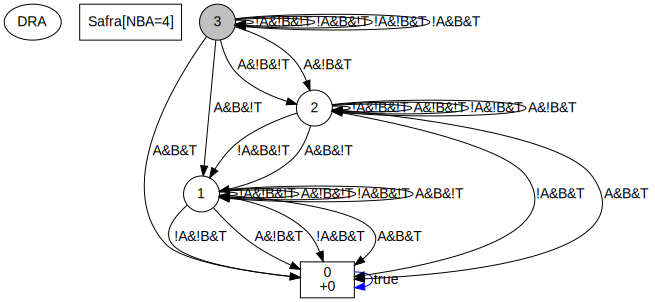

In [5]:
env = CurrentWorld(LTL)
with open("my.dot", "r") as dotfile:
    text = dotfile.read()
Source(text)

In [7]:
render(env,np.unravel_index(167,(10,10,4))[:2],0)

In [12]:
plt.close("all")

In [11]:
for i in range(10):
    a = np.random.randint(env.nA)
    print a
    ns,r,d,_ = env.step(a)
    ns = np.unravel_index(ns,(10,10,4))[:2]
    render(env,ns,a)
    

3
4
1
0
2
0
4
4
0
1


In [8]:
env.step(0)

(127, -1, False, {'prob': 0.8})

In [ ]:
env.

In [ ]:
with tf.Session() as sess:
    
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    env.seed(RANDOM_SEED)
    
    state_dim = 3
    action_dim = 5
    
    Qnet = QNet(sess, state_dim, action_dim, LEARNING_RATE, TAU, MINIBATCH_SIZE, SAVE_DIR)
    
    train(sess, env, Qnet)

In [ ]:
tf.reset_default_graph()

In [ ]:
plot_path(env, LTL, "./saved_model/Mar_29_07-25_OR/ddqn.ckpt", LEARNING_RATE, TAU, MINIBATCH_SIZE, SAVE_DIR)

In [ ]:
plt.close("all")

In [ ]:
Opt_Policy = {}
restore_path = "./saved_model/Mar_17_04-08_10by10_dynamic_normal/ddqn.ckpt"

with tf.Session() as sess:
    
#     np.random.seed(RANDOM_SEED)
#     tf.set_random_seed(RANDOM_SEED)
#     env.seed(RANDOM_SEED)
    
    state_dim = 3
    action_dim = env.nA
    
    Qnet = QNet(sess, state_dim, action_dim, LEARNING_RATE, TAU, MINIBATCH_SIZE, SAVE_DIR)
    saver = tf.train.Saver()
    saver.restore(sess, restore_path)
    
    for state in range(env.nS):
        state_for_nn = np.array(np.unravel_index(state, env.shape)).reshape(1, state_dim)
        action = Qnet.predict_a_from_save(state_for_nn, restore_path)
        Opt_Policy[state] = action[0]
    
    

In [ ]:
action_dict = {0: u"\u2191", 1: u"\u2192", 2: u"\u2193", 3: u"\u2190", 4: u"\u2613"}
worlds = [np.zeros((env.shape[0], env.shape[1])) for i in range(env.shape[2])]
color_dict = {ap: color+1 for color, ap in enumerate(env.ap_dict.keys())}

for world in worlds:
    world[env.start_state[:-1]] = len(env.ap_dict) + 1
    for i in env.coord_dict.keys():
        if len(env.coord_dict[i]) >=1:
            world[i] = color_dict[env.coord_dict[i][0]]
            
fig, ax = plt.subplots(2, int(np.ceil(len(worlds)/2)) )

for i in range(len(worlds)):
    index = np.unravel_index(i, (2, int( np.ceil(len(worlds)/2)) ) )
    ax[index[0]][index[1]].imshow(worlds[i])
    
for k in range(len(worlds)):
    index = np.unravel_index(k, (2, int(np.ceil(len(worlds)/2))))
    for i in env.ap_dict.keys():
        for j in env.ap_dict[i]:
            ax[index[0]][index[1]].annotate(i, xy=(j[1] - 0.13, j[0] + 0.13), fontsize=5, color=(0,0,0))

for i in range(len(worlds)):
    index = np.unravel_index(i, (2, int(np.ceil(len(worlds)/2))))
    ax[index[0]][index[1]].set_title("Rabin State = " + str(i))
    ax[index[0]][index[1]].annotate("R", xy=(env.start_state[1] - 0.13, env.start_state[0] + 0.13), fontsize=5, color=(1,0,0))
    for state, action in Opt_Policy.items():
        state = np.unravel_index(state, env.shape)
        if state[-1] == i:
            ax[index[0]][index[1]].annotate(action_dict[action], xy=(state[1]-0.13, state[0]+0.13), fontsize=10, color=(1,1,1))

In [ ]:
# Test how many times LTL are violated in 100 runs -- Static Environment

saved_path = "./saved_model/Mar_16_21-59_10by10_indefinitely_run/ddqn.ckpt"

state_dim = 3
action_dim = env.nA

counter = 0

c_coords = [np.ravel_multi_index(i, env.shape[:-1]) for i in env.ap_dict["C"]]

with tf.Session() as sess:
    Qnet = QNet(sess, state_dim, action_dim, LEARNING_RATE, TAU, MINIBATCH_SIZE, SAVE_DIR)
    saver = tf.train.Saver()
    saver.restore(sess, saved_path)
    
    for num_i in range(100):
    
        state = env.reset()
        done = False

        for t in count():
            state_1d = state
            state = np.reshape(list(np.unravel_index(state, env.shape)), (1, state_dim))
            state_for_plot = tuple(state[0][:2])
            action = Qnet.predict_a_from_save(state, saved_path)
            next_state,_,done,_ = env.step(action[0])
            next_3d = np.unravel_index(next_state, env.shape)
            next_2d = next_3d[:-1]
            next_1d = np.ravel_multi_index(next_2d, env.shape[:-1])
    #         render(env, state_for_plot, action[0])
            if next_1d in c_coords:
                counter += 1
            state = next_state
    #         if t%20 == 0:
    #             plt.close("all")
            if done:
                break

In [ ]:
# Test how many times LTL are violated in 100 runs -- Dynamic Environment

saved_path = "./saved_model/Mar_17_03-15_10by10_dyn_indefinite/ddqn.ckpt"

state_dim = 3
action_dim = env.nA

counter = 0

c_coords = [np.ravel_multi_index(i, env.shape[:-1]) for i in env.ap_dict["C"]]

with tf.Session() as sess:
    Qnet = QNet(sess, state_dim, action_dim, LEARNING_RATE, TAU, MINIBATCH_SIZE, SAVE_DIR)
    saver = tf.train.Saver()
    saver.restore(sess, saved_path)
    
    for num_i in range(100):
    
        state = env.reset()
        done = False

        for t in count():
            state_1d = state
            state = np.reshape(list(np.unravel_index(state, env.shape)), (1, state_dim))
            state_for_plot = tuple(state[0][:2])
            action = Qnet.predict_a_from_save(state, saved_path)
            next_state,_,done,info = env.step(action[0])
            next_3d = np.unravel_index(next_state, env.shape)
            next_2d = next_3d[:-1]
            next_1d = np.ravel_multi_index(next_2d, env.shape[:-1])
    #         render(env, state_for_plot, action[0])
            if next_1d in c_coords and info != "disappear":
                counter += 1
            state = next_state
    #         if t%20 == 0:
    #             plt.close("all")
            if done:
                break

In [ ]:
counter